# Project Notebook

## Imports

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input
from keras.models import Model
from tensorflow.nn import depth_to_space
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing.image import array_to_img
#from keras.preprocessing import image_dataset_from_directory
from PIL import Image
import math
from scipy.signal import convolve2d

2022-05-19 12:56:11.255890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 12:56:11.255924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from load_data import loadDataR09, loadDataR18
from utils import *
from SRCNN import getModel, compileModel, trainModel

## LOAD DATA

In [3]:
upscale_factor = 4

Experiment on small resolution data : 

In [4]:
ssh_R18, sst_R18, ssh_R18_norm, sst_R18_norm, ssh_R72, sst_R72 = loadDataR18( upscale_factor )

Experiment on higher resolution data:

In [5]:
ssh_R09, sst_R09, ssh_R09_norm, sst_R09_norm, ssh_R36, sst_R18 = loadDataR09( upscale_factor )

## SRCNN 

In [6]:
srcnn, callbacks, epochs, checkpoint_filepath = compileModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

2022-05-19 12:56:17.961627: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-19 12:56:17.961666: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-05-19 12:56:17.962229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Small Resolution 

(Training might be skipped)

In [ ]:
batch_size = 16
trainModel( srcnn, batch_size, ssh_R72, ssh_R18_norm, callbacks, epochs )

#### Results

In [7]:
srcnn.load_weights(checkpoint_filepath)

In [14]:
save_path = "./Save/exp1_srcnn_plot"
bicubic_predictions, bicubic_rmse, bicubic_psnr = bicubicMetrics( ssh_R72, ssh_R18 )
srcnn_predictions, srcnn_rmse, srcnn_psnr = srcnnMetrics( srcnn, ssh_R72, ssh_R18)

print("Average bicubic RMSE (m): ", np.mean(bicubic_rmse))
print("Average bicubic PSNR: ", np.mean(bicubic_psnr))
print("Average srcnn RMSE (m): ", np.mean(srcnn_rmse))
print("Average srcnn PSNR: ", np.mean(srcnn_psnr))

Average bicubic RMSE (m):  0.14560837199765492
Average bicubic PSNR:  23.04621296821734
Average srcnn RMSE (m):  0.10014087439015143
Average srcnn PSNR:  26.36898275305834


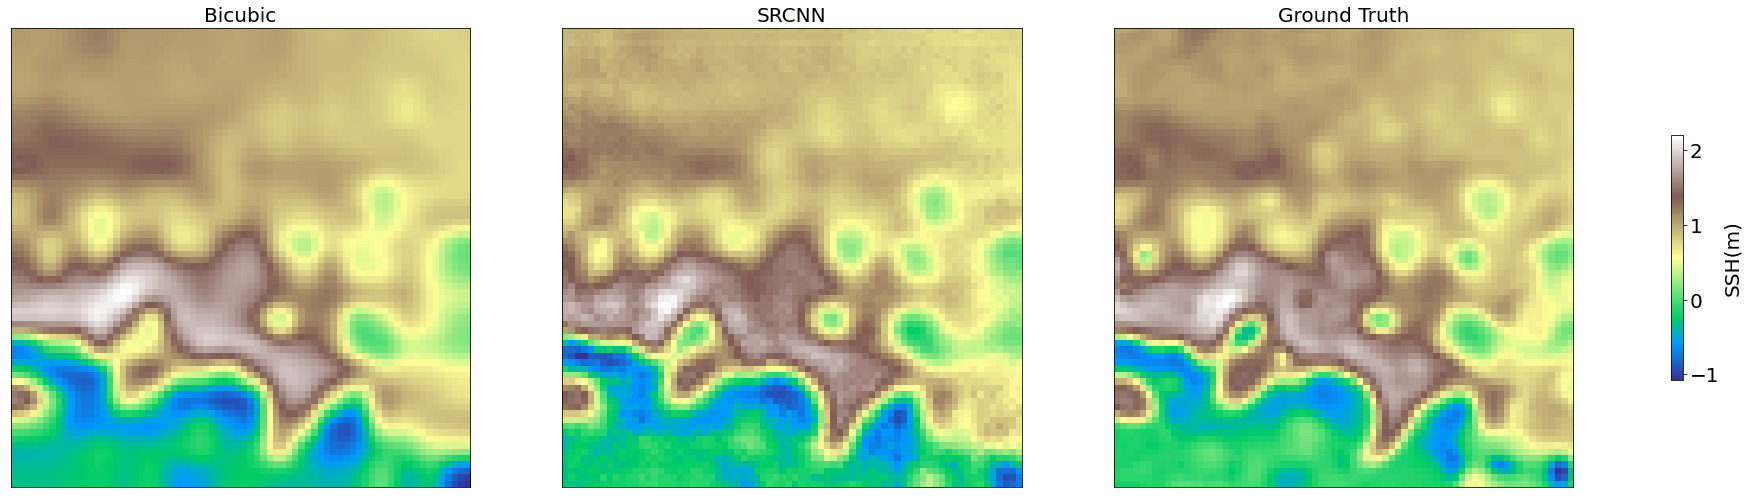

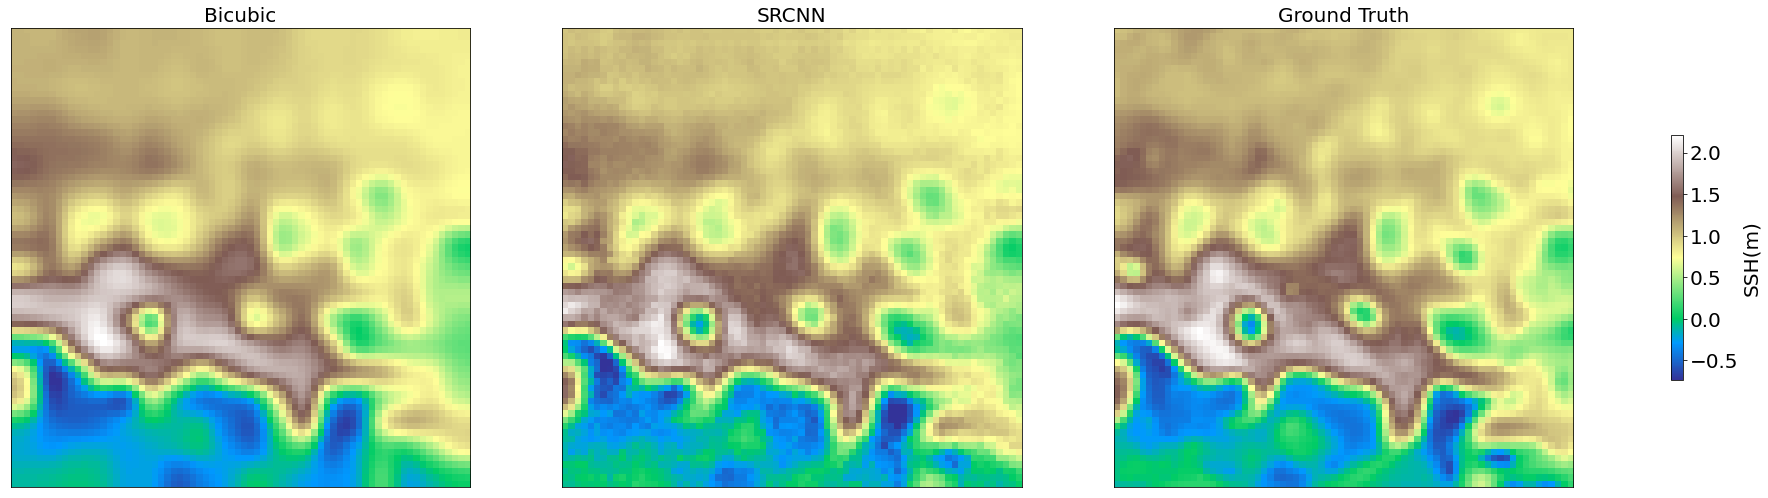

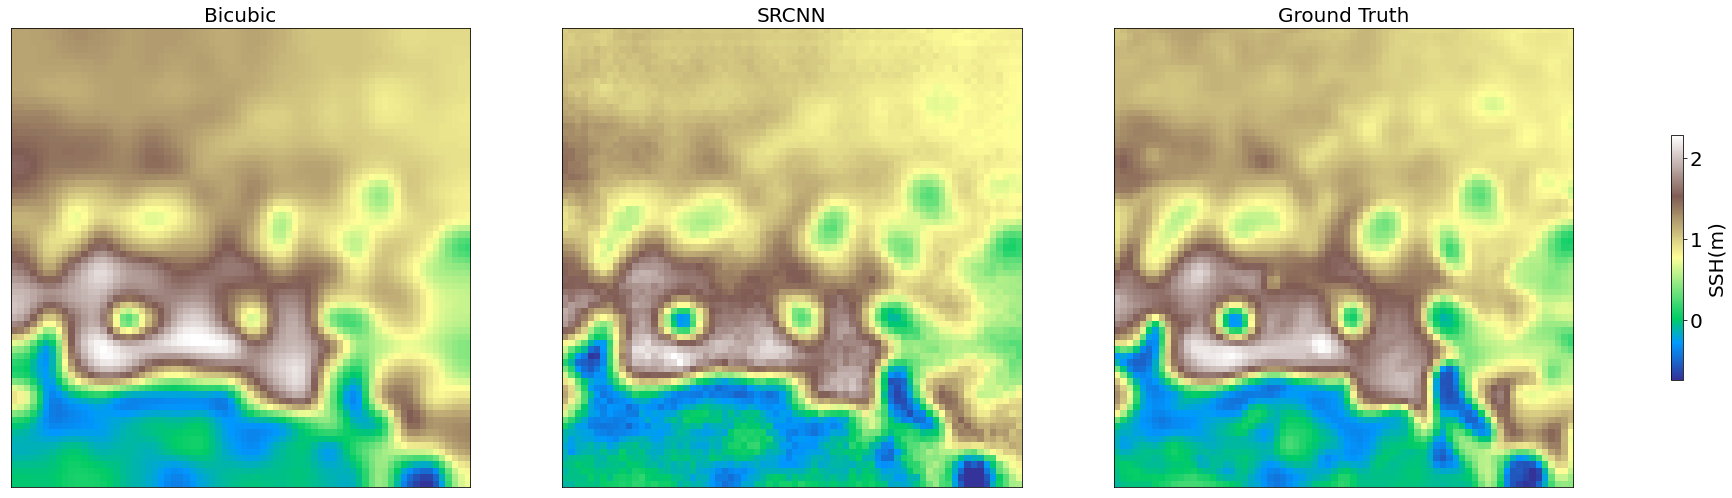

In [27]:
for i in range(3):
    plot_line([bicubic_predictions[i*10], srcnn_predictions[i*10], ssh_R18[i*10]], ["Bicubic", "SRCNN", "Ground Truth"], "terrain", save_path+str(i), center_colormap=False)

*comment* : we already observe how bicubic interpolation has the tendancy to blur edges compared to our method

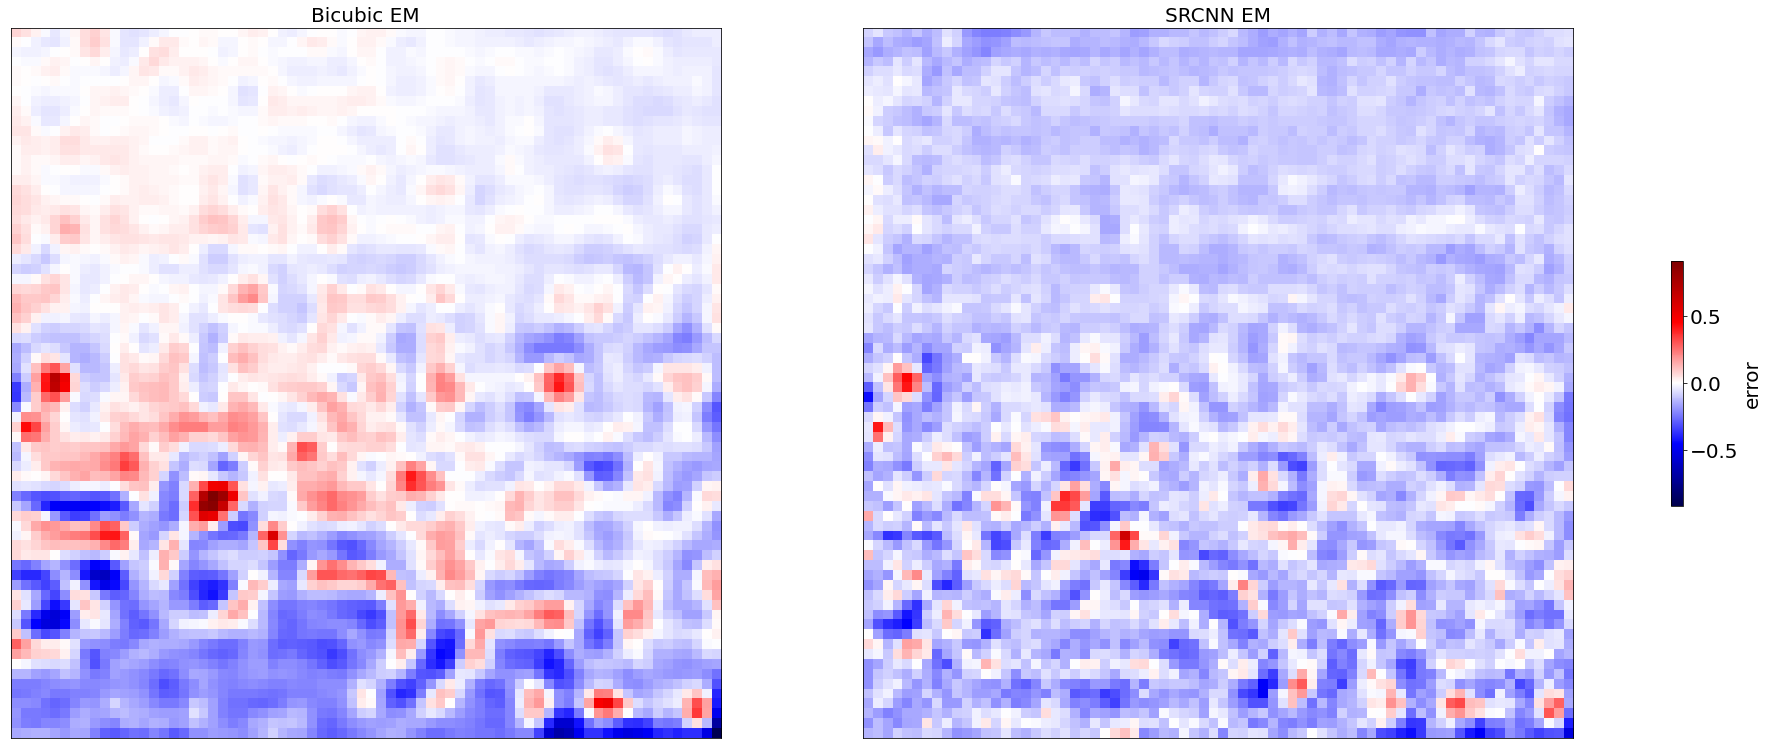

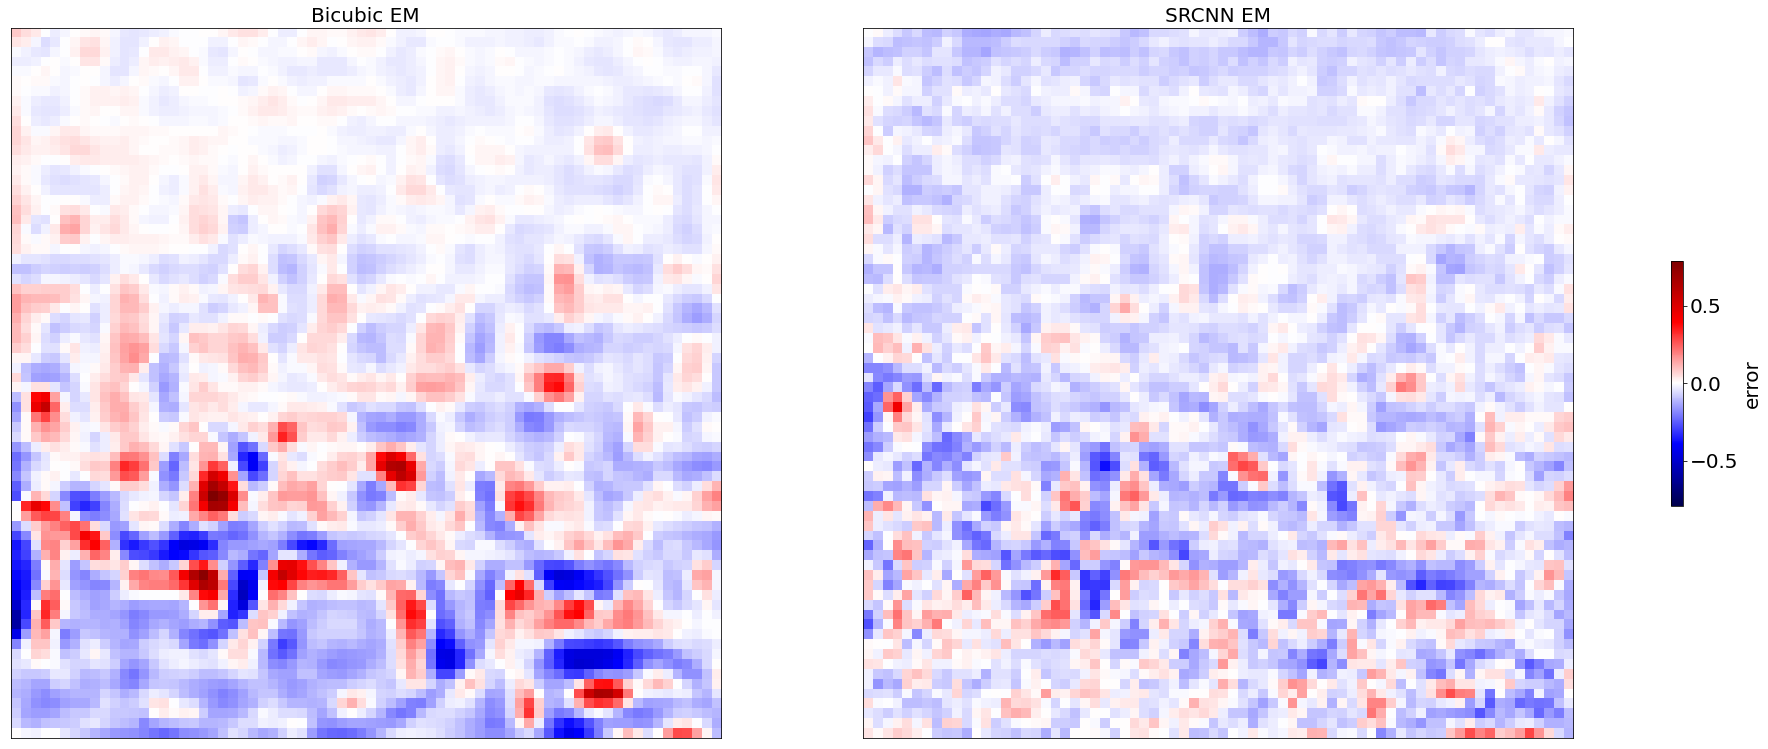

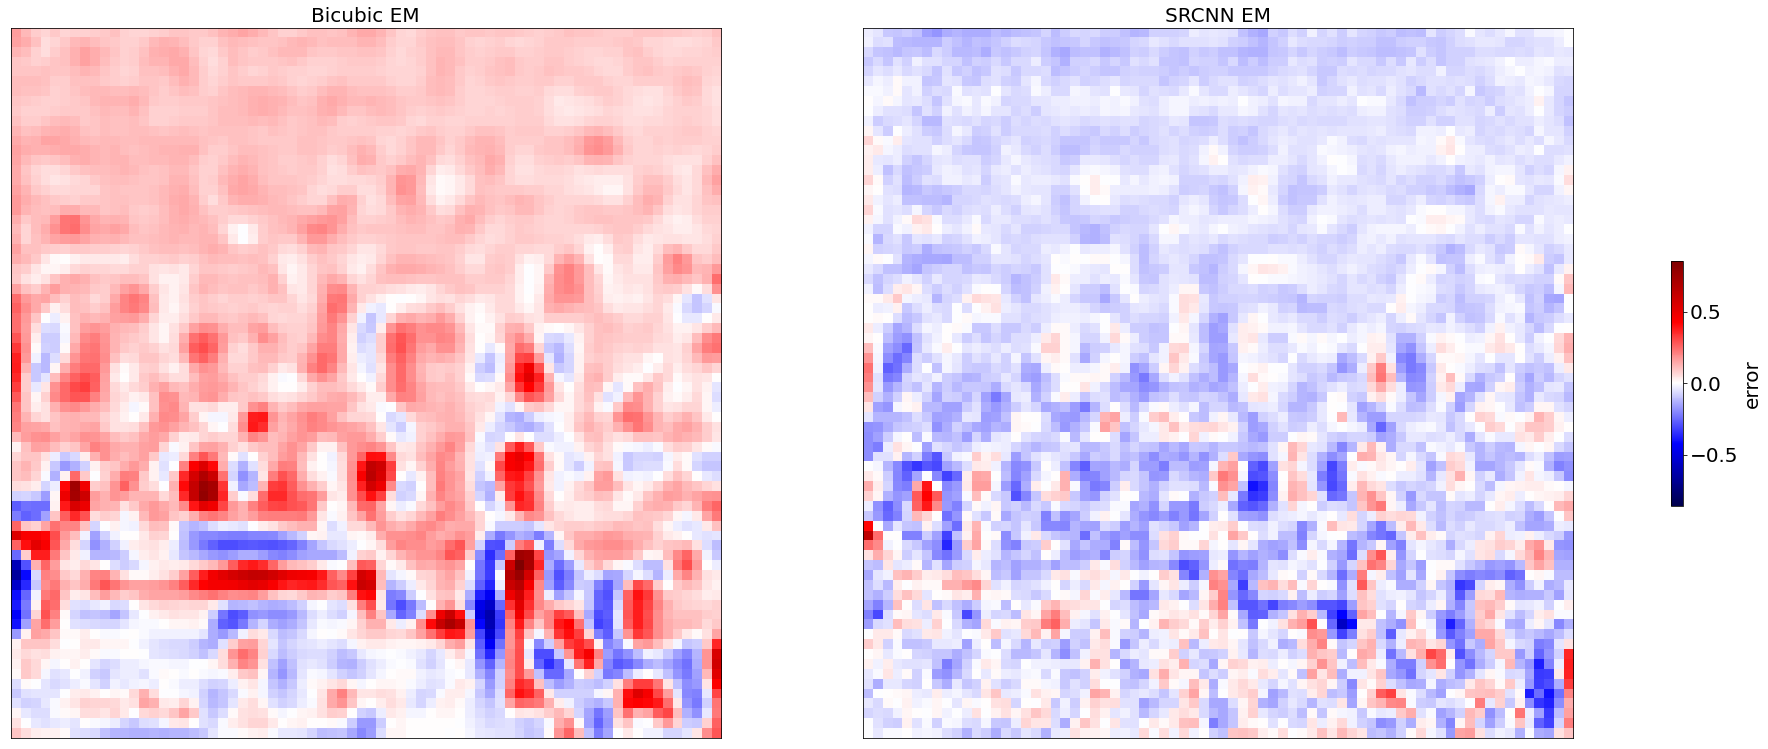

In [28]:
save_path = "./Save/exp1_srcnn_em"
for i in range(0,30,10):
    plot_line(
        [bicubic_predictions[i]-ssh_R18[i], srcnn_predictions[i]-ssh_R18[i]], 
        ["Bicubic EM", "SRCNN EM"], 
        "seismic",
        save_path+str(i), 
        label="error",
        center_colormap=True
    )

*comment :* same idea here, bicubic error are high and homogeneous around edges (related to blurred edges),
while srcnn errors are more punctual, especially and tiny regions.

### High resolution

Epoch 1/100


2022-05-19 13:59:58.620846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60715008 exceeds 10% of free system memory.
2022-05-19 13:59:58.702691: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60715008 exceeds 10% of free system memory.


23/23 [==============================] - 5s 169ms/step - loss: 0.0071 - mse: 0.0071 - PSNR: 27.0329 - val_loss: 0.0066 - val_mse: 0.0066 - val_PSNR: 21.8511
Epoch 2/100
23/23 [==============================] - 4s 179ms/step - loss: 0.0024 - mse: 0.0024 - PSNR: 27.4861 - val_loss: 4.6633e-04 - val_mse: 4.6632e-04 - val_PSNR: 33.3157
Epoch 3/100
23/23 [==============================] - 4s 165ms/step - loss: 4.2379e-04 - mse: 4.2379e-04 - PSNR: 33.9258 - val_loss: 3.0544e-04 - val_mse: 3.0544e-04 - val_PSNR: 35.1875
Epoch 4/100
23/23 [==============================] - 4s 169ms/step - loss: 2.4393e-04 - mse: 2.4393e-04 - PSNR: 36.1737 - val_loss: 2.2462e-04 - val_mse: 2.2462e-04 - val_PSNR: 36.5123
Epoch 5/100
23/23 [==============================] - 4s 169ms/step - loss: 2.0246e-04 - mse: 2.0246e-04 - PSNR: 36.9680 - val_loss: 1.8498e-04 - val_mse: 1.8498e-04 - val_PSNR: 37.3477
Epoch 6/100
23/23 [==============================] - 4s 186ms/step - loss: 1.8392e-04 - mse: 1.8392e-04 - PSNR:

23/23 [==============================] - 4s 159ms/step - loss: 9.3330e-05 - mse: 9.3330e-05 - PSNR: 40.4026 - val_loss: 8.2206e-05 - val_mse: 8.2206e-05 - val_PSNR: 40.9286
Epoch 46/100
23/23 [==============================] - 4s 164ms/step - loss: 9.1245e-05 - mse: 9.1245e-05 - PSNR: 40.4918 - val_loss: 8.0846e-05 - val_mse: 8.0846e-05 - val_PSNR: 41.0029
Epoch 47/100
23/23 [==============================] - 4s 158ms/step - loss: 9.0212e-05 - mse: 9.0212e-05 - PSNR: 40.5419 - val_loss: 8.0557e-05 - val_mse: 8.0557e-05 - val_PSNR: 41.0183
Epoch 48/100
23/23 [==============================] - 4s 163ms/step - loss: 9.0035e-05 - mse: 9.0035e-05 - PSNR: 40.5528 - val_loss: 8.0810e-05 - val_mse: 8.0810e-05 - val_PSNR: 41.0024
Epoch 49/100
23/23 [==============================] - 4s 175ms/step - loss: 9.5394e-05 - mse: 9.5394e-05 - PSNR: 40.3326 - val_loss: 9.3279e-05 - val_mse: 9.3279e-05 - val_PSNR: 40.3614
Epoch 50/100
23/23 [==============================] - 4s 167ms/step - loss: 1.1293e

23/23 [==============================] - 4s 163ms/step - loss: 7.8147e-05 - mse: 7.8147e-05 - PSNR: 41.1831 - val_loss: 7.0170e-05 - val_mse: 7.0170e-05 - val_PSNR: 41.6262
Epoch 90/100
23/23 [==============================] - 4s 161ms/step - loss: 7.7306e-05 - mse: 7.7306e-05 - PSNR: 41.2335 - val_loss: 6.9528e-05 - val_mse: 6.9528e-05 - val_PSNR: 41.6663
Epoch 91/100
23/23 [==============================] - 4s 161ms/step - loss: 7.6850e-05 - mse: 7.6850e-05 - PSNR: 41.2616 - val_loss: 6.9187e-05 - val_mse: 6.9187e-05 - val_PSNR: 41.6872
Epoch 92/100
23/23 [==============================] - 4s 160ms/step - loss: 7.9358e-05 - mse: 7.9358e-05 - PSNR: 41.1402 - val_loss: 7.6558e-05 - val_mse: 7.6558e-05 - val_PSNR: 41.2312
Epoch 93/100
23/23 [==============================] - 4s 161ms/step - loss: 1.1977e-04 - mse: 1.1977e-04 - PSNR: 39.7927 - val_loss: 2.0930e-04 - val_mse: 2.0930e-04 - val_PSNR: 36.8307
Epoch 94/100
23/23 [==============================] - 4s 161ms/step - loss: 3.2331e

INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


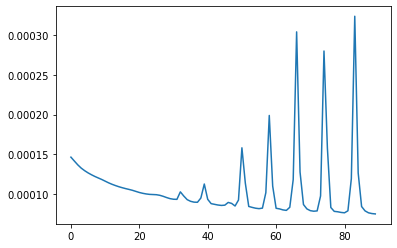

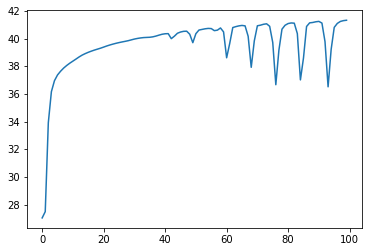

In [29]:
batch_size = 16
trainModel( srcnn, batch_size, ssh_R36, ssh_R09_norm, callbacks, epochs )

In [30]:
srcnn.load_weights(checkpoint_filepath)

In [34]:
save_path = "./Save/exp2_srcnn_plot"
bicubic_predictions, bicubic_rmse, bicubic_psnr = bicubicMetrics( ssh_R36, ssh_R09 )
srcnn_predictions, srcnn_rmse, srcnn_psnr = srcnnMetrics( srcnn, ssh_R36, ssh_R09)

print("Average bicubic RMSE (m): ", np.mean(bicubic_rmse))
print("Average bicubic PSNR: ", np.mean(bicubic_psnr))
print("Average srcnn RMSE (m): ", np.mean(srcnn_rmse))
print("Average srcnn PSNR: ", np.mean(srcnn_psnr))

Average bicubic RMSE (m):  0.027453032120097542
Average bicubic PSNR:  31.76214629124577
Average srcnn RMSE (m):  0.017234663254112846
Average srcnn PSNR:  35.96184727619892


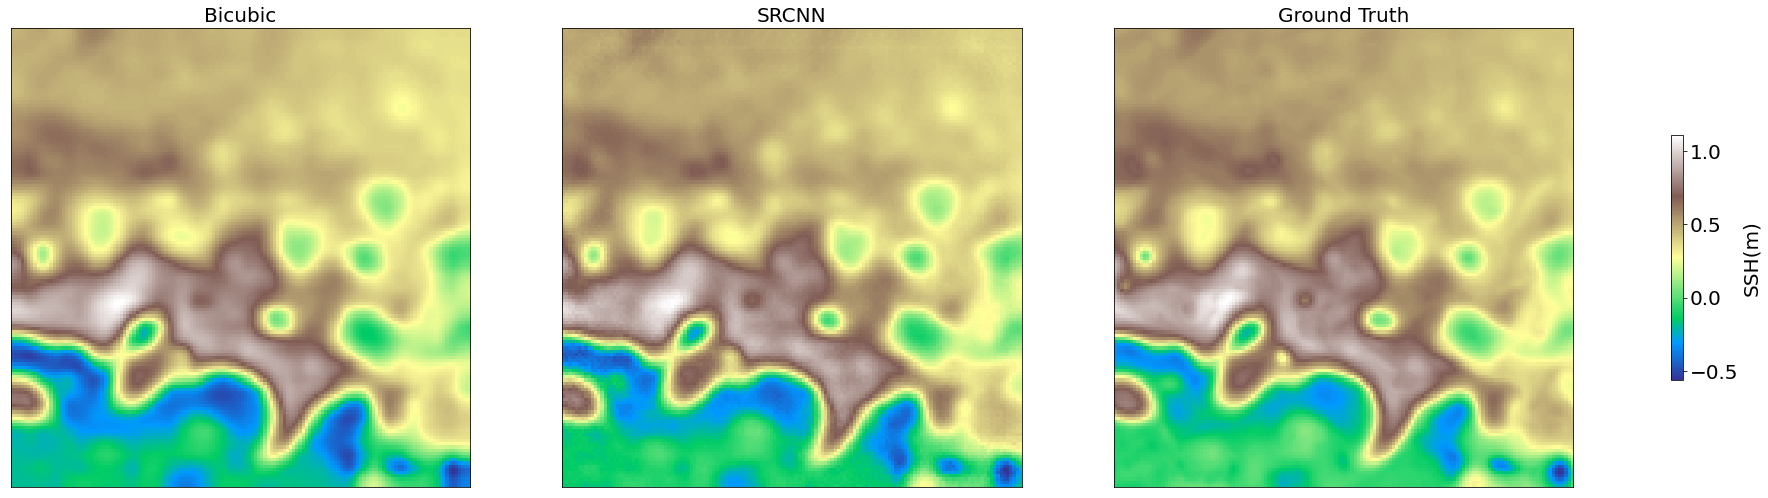

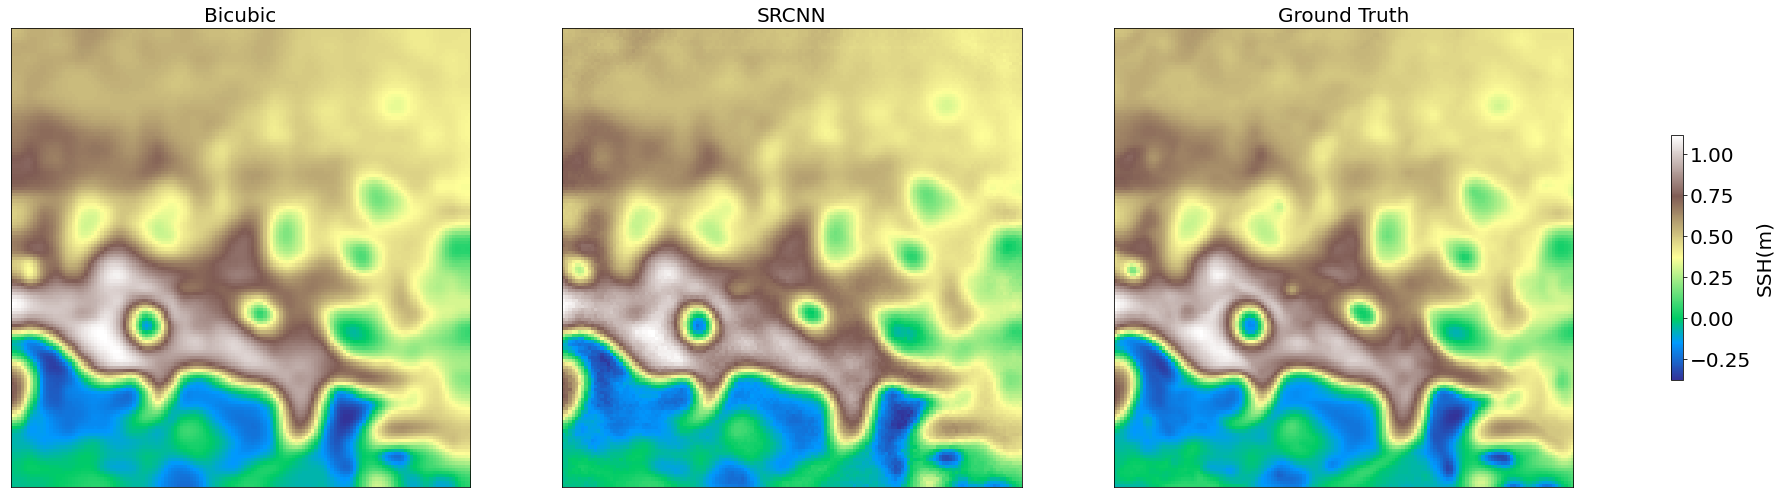

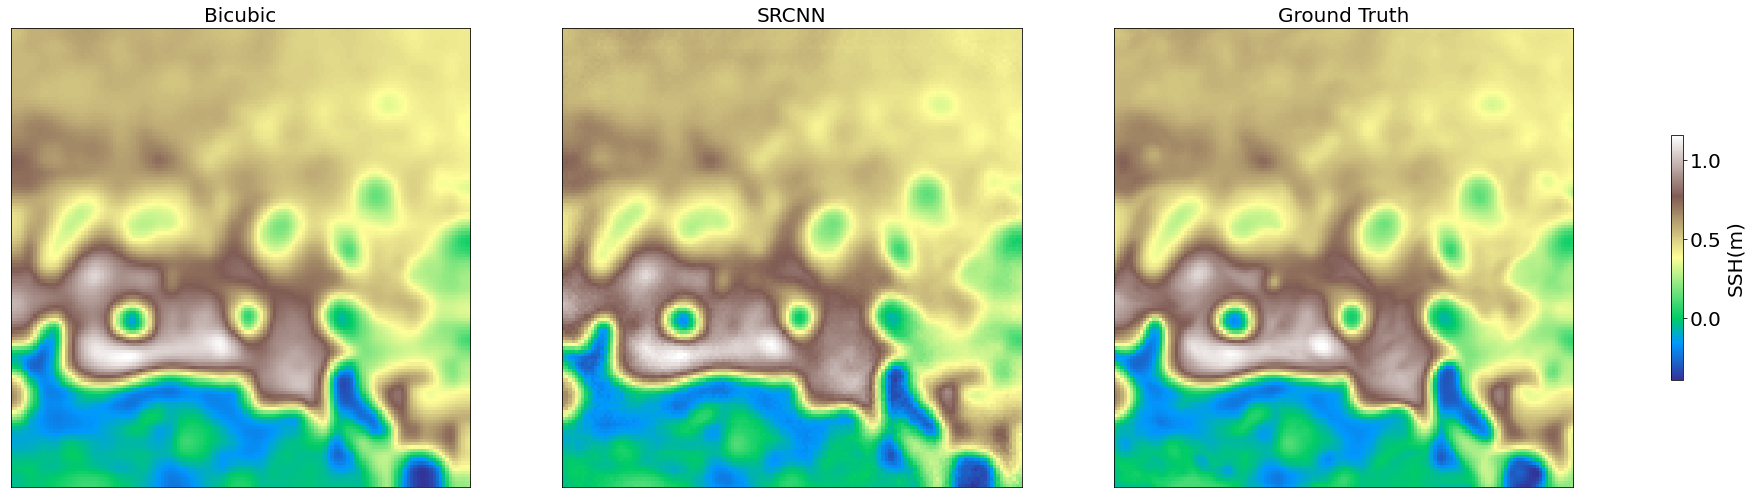

In [35]:
for i in range(3):
    plot_line(
        [bicubic_predictions[i*10], 
         srcnn_predictions[i*10], 
         ssh_R09[i*10]], 
        ["Bicubic", "SRCNN", "Ground Truth"], 
        "terrain", 
        save_path+str(i), 
        center_colormap=False
    )

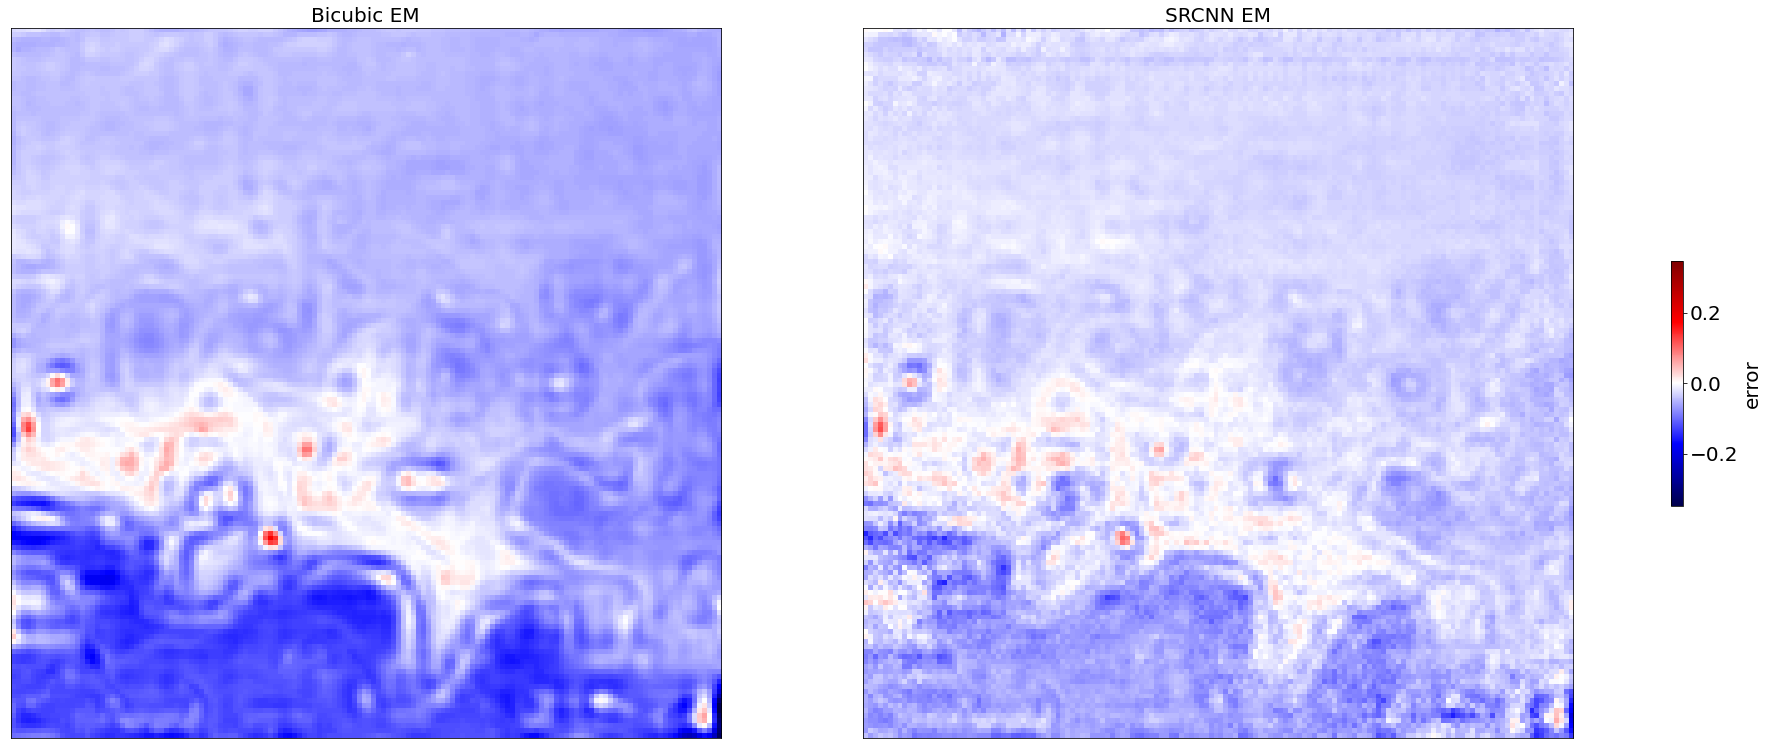

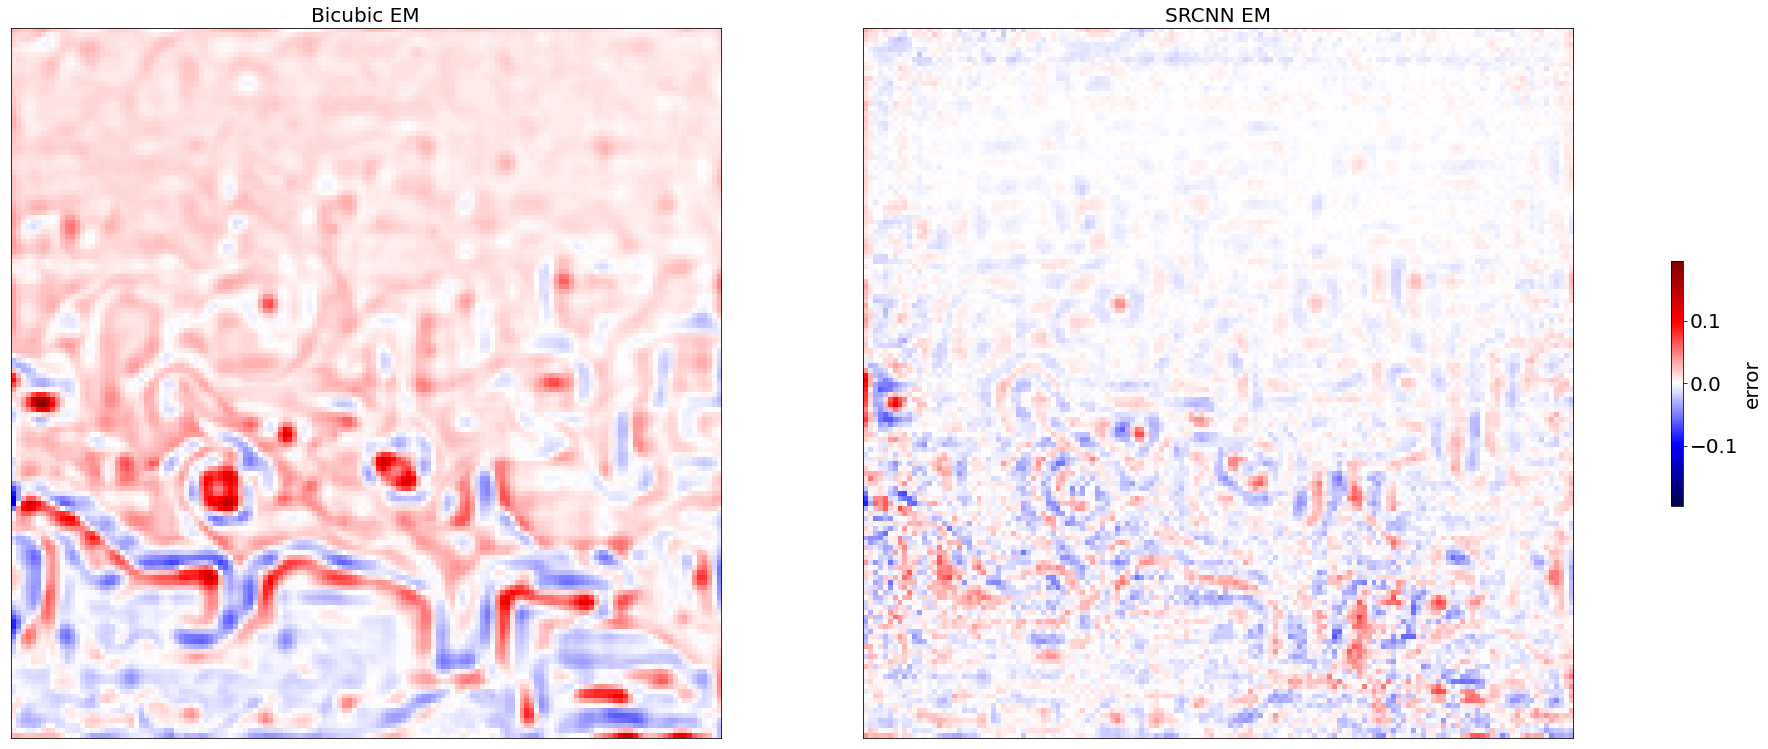

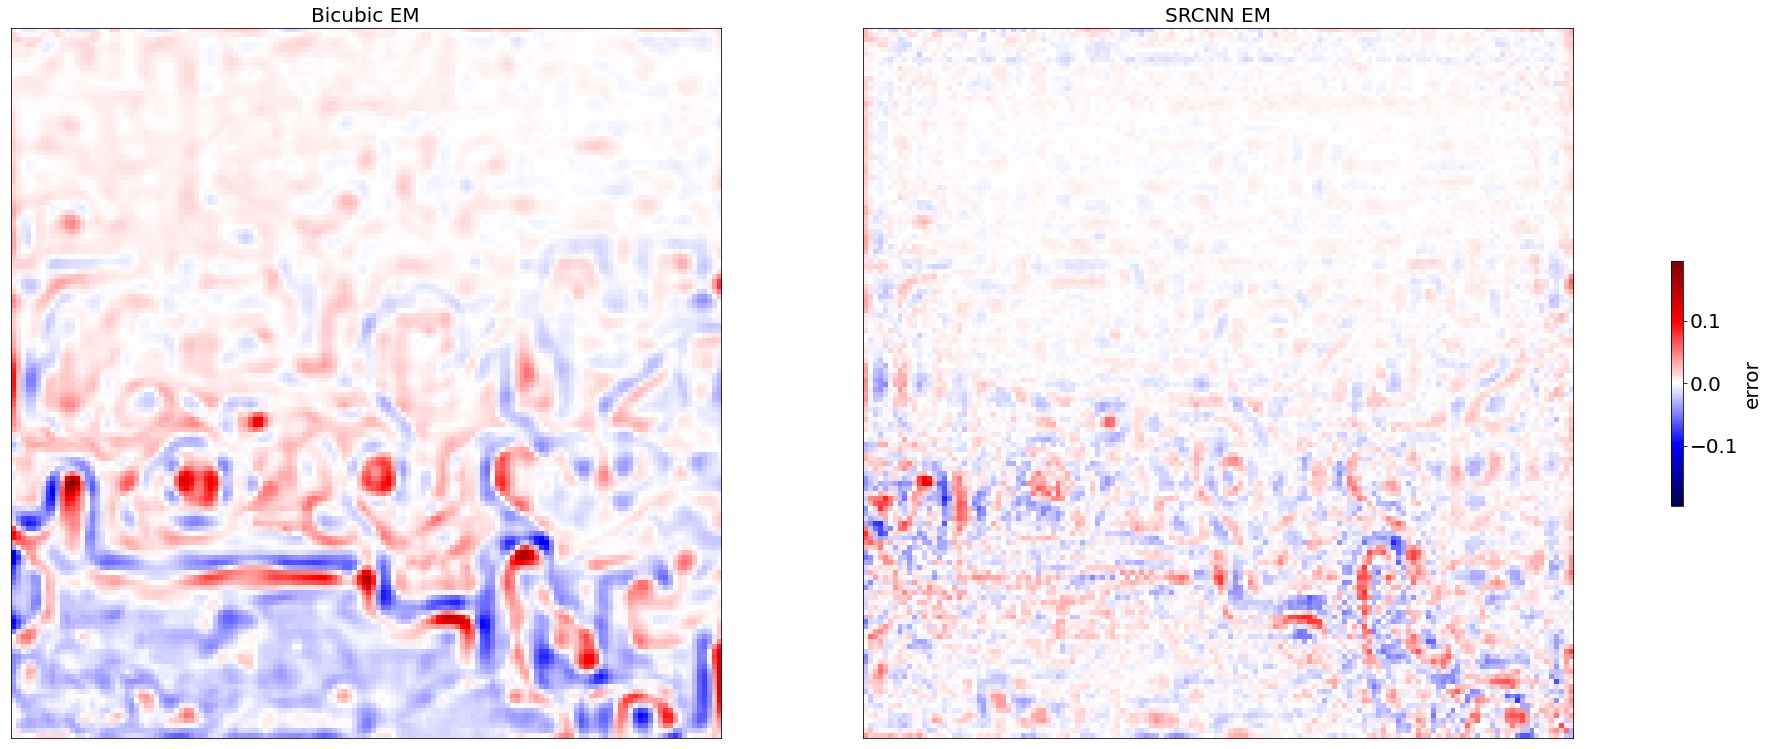

In [37]:
save_path = "./Save/exp2_srcnn_em"
for i in range(0,30,10):
    plot_line(
        [bicubic_predictions[i]-ssh_R09[i], srcnn_predictions[i]-ssh_R09[i]], 
        ["Bicubic EM", "SRCNN EM"], 
        "seismic",
        save_path+str(i), 
        label="error",
        center_colormap=True
    )

*Comment* : Here we sea much more clearly the 'checkerboard artifact' with the SRCNN.

### DIPCI

In [ ]:
dipci, callbacks, epochs, checkpoint_filepath = compile()

### Training (to skip)

In [ ]:
dipci = train(dipci, ssh_lr, sst_lr, ssh_norm, callbacks, epochs)

### Results

In [ ]:
#dipci.load_weights(checkpoint_filepath)

In [ ]:
test_dipci(dipci, ssh_lr[:366], sst_lr[:366], ssh[:366])